In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
import fasttext
import fasttext.util
ft = fasttext.load_model('/Users/ayush.garg/Desktop/wiki.hi/wiki.hi.bin')

In [4]:
word = "पूरे"
print("Embedding Shape is {}".format(ft.get_word_vector(word).shape))
print("Nearest Neighbors to {} are:".format(word))
ft.get_nearest_neighbors(word) 

Embedding Shape is (300,)
Nearest Neighbors to पूरे are:


[(0.5375568270683289, 'भर'),
 (0.5343677401542664, 'पुरे'),
 (0.49903032183647156, 'सारे'),
 (0.49650809168815613, 'पूरा'),
 (0.49516043066978455, 'समूचे'),
 (0.47405508160591125, 'सम्पूर्ण'),
 (0.4724029302597046, 'भटूरे'),
 (0.46704691648483276, 'अपने'),
 (0.4666309058666229, 'संपूर्ण'),
 (0.46629437804222107, 'ज्\u200d़यादा')]

In [5]:
train = pd.read_csv('~/Downloads/emoHi-train.csv.zip', index_col = 0)
test = pd.read_csv('~/Downloads/emoHi-test.csv.zip', index_col=0)

In [6]:
train

,id,labels,text
0,eebbqej,[27],मेरा पसंदीदा खाना कुछ भी है जो मुझे खुद नहीं ब...
1,ed00q6i,[27],"अब अगर वह खुद से दूर हो जाता है, तो हर कोई सोच..."
2,eezlygj,[2],बकवास बेअदब आईएसओिंग क्यों है?
3,ed7ypvh,[14],उसे खतरा महसूस कराने के लिए
4,ed0bdzj,[3],डर्टी सदर्न वेंकर्स
...,...,...,...
43405,edsb738,[18],आपको अच्छी तरह से जोड़ा गया मुझे अभी धनुष मिला...
43406,ee7fdou,[6],हमेशा सोचा कि यह मजाकिया था लेकिन क्या यह किसी...
43407,efgbhks,[3],तुम्हारी किस बारे में बोलने की इच्छा थी? जो कु...
43408,ed1naf8,[13],"एक बपतिस्मा की तरह, सेक्सी परिणामों के साथ!"


In [7]:
train['labels'] = train['labels'].str.replace(r'[', '')
train['labels'] = train['labels'].str.replace(r']', '')
train['labels'] = train['labels'].str.strip()

/var/folders/t_/jx0zym4j5mgf__cxw2drjvwm0000gn/T/ipykernel_6445/3604601887.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['labels'] = train['labels'].str.replace(r'[', '')
/var/folders/t_/jx0zym4j5mgf__cxw2drjvwm0000gn/T/ipykernel_6445/3604601887.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train['labels'] = train['labels'].str.replace(r']', '')


In [8]:
test['labels'] = test['labels'].str.replace(r'[', '')
test['labels'] = test['labels'].str.replace(r']', '')
test['labels'] = test['labels'].str.strip()

/var/folders/t_/jx0zym4j5mgf__cxw2drjvwm0000gn/T/ipykernel_6445/43894735.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['labels'] = test['labels'].str.replace(r'[', '')
/var/folders/t_/jx0zym4j5mgf__cxw2drjvwm0000gn/T/ipykernel_6445/43894735.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test['labels'] = test['labels'].str.replace(r']', '')


In [9]:
train['label'] = train['labels'].str.split(' ',expand=True)[0].astype(int)
test['label'] = test['labels'].str.split(' ',expand=True)[0].astype(int)

### Convert to TF Dataset and Train/Test Split

In [10]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train['text'].values, tf.string),
            tf.cast(train['label'].values, tf.int32)
        )
    )
)

2022-05-03 17:42:24.863291: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test['text'].values, tf.string),
            tf.cast(test['label'].values, tf.int32)
        )
    )
)

In [12]:
batch_size = 16

In [13]:
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Vectorization Layer

In [14]:
max_features = 20000
sequence_length = 100

vectorize_layer = layers.TextVectorization(
    standardize="strip_punctuation",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
train_text = train_dataset.map(lambda x, y: x)

In [16]:
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
train_ds = train_dataset.map(vectorize_text)
val_ds = test_dataset.map(vectorize_text)

In [19]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [20]:
print ("Words in training set are "+str(len(voc)))

Words in training set are 20000


In [21]:
print ("Words in fasttext vocabulary are "+str(len(ft.words)))

Words in fasttext vocabulary are 158016


### Generate Fasttext embeds

In [22]:
num_tokens = len(voc) + 2
embedding_dim = 300


In [23]:
embedding_matrix = np.zeros((num_tokens, embedding_dim))

In [24]:
fastext_vocab = set(ft.words)

In [25]:
hits = 0
misses = 0

for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    embedding_matrix[i] = embedding_vector
    if word in fastext_vocab:
        hits += 1
    else:
        misses += 1

### Creating embedding layer

In [26]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Model definition

In [27]:
model = tf.keras.Sequential([
  embedding_layer,
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(28, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         6000600   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense (Dense)               (None, 28)                8428      
                                                                 
Total params: 6,009,028
Trainable params: 8,428
Non-trainable params: 6,000,600
__________________________________________

In [28]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [29]:
epochs = 350
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/350
2714/2714 [==============================] - 6s 2ms/step - loss: 2.7972 - sparse_categorical_accuracy: 0.2937 - val_loss: 2.6899 - val_sparse_categorical_accuracy: 0.2959
Epoch 2/350
2714/2714 [==============================] - 6s 2ms/step - loss: 2.6374 - sparse_categorical_accuracy: 0.2959 - val_loss: 2.5979 - val_sparse_categorical_accuracy: 0.2981
Epoch 3/350
2714/2714 [==============================] - 6s 2ms/step - loss: 2.5693 - sparse_categorical_accuracy: 0.3003 - val_loss: 2.5428 - val_sparse_categorical_accuracy: 0.3044
Epoch 4/350
2714/2714 [==============================] - 6s 2ms/step - loss: 2.5236 - sparse_categorical_accuracy: 0.3070 - val_loss: 2.5017 - val_sparse_categorical_accuracy: 0.3131
Epoch 5/350
2714/2714 [==============================] - 6s 2ms/step - loss: 2.4882 - sparse_categorical_accuracy: 0.3161 - val_loss: 2.4682 - val_sparse_categorical_accuracy: 0.3226
Epoch 6/350
2714/2714 [==============================] - 7s 3ms/step - loss: 2.4590 -

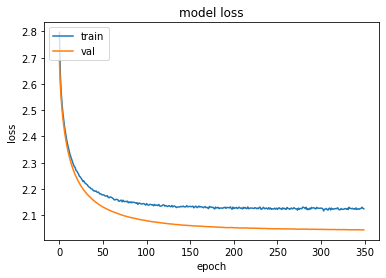

In [30]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
val_softmax = model.predict(val_ds)

In [32]:
val_labels = np.argmax(val_softmax, axis=1)

In [33]:
val_pd = test

In [34]:
val_pd['pred_labels'] = val_labels

In [35]:
val_pd

,id,labels,text,label,pred_labels
0,eecwqtt,25,मुझे आपकी स्थिति के लिए वास्तव में खेद है :( ह...,25,27
1,ed5f85d,0,यह अद्भुत है क्योंकि यह भयानक है। पर साथ नहीं।,0,0
2,een27c3,13,"किंग्स फैन यहाँ, आप लोगों को शुभकामनाएँ! देखने...",13,0
3,eelgwd1,15,"मुझे यह नहीं पता था, आज मुझे कुछ सिखाने के लिए...",15,15
4,eem5uti,27,वे हज़ारों वर्षों तक भूतिया धरती से ऊब चुके थे...,27,27
...,...,...,...,...,...
5422,efeeasc,15,धन्यवाद। मुझे अस्पताल में भर्ती होने के बाद भी...,15,15
5423,ef9c7s3,4,अच्छा यह समझ में आता है।,4,0
5424,efbiugo,27,डैडी मुद्दे [NAME],27,27
5425,efbvgp9,0,बहुत खुशी है कि मैंने कुछ महीने पहले उस सब्रेड...,0,0


In [36]:
from sklearn.metrics import classification_report

In [37]:
print (classification_report(val_pd['label'], val_pd['pred_labels']))

              precision    recall  f1-score   support

           0       0.49      0.42      0.45       504
           1       0.50      0.12      0.19       252
           2       0.35      0.07      0.11       197
           3       0.19      0.02      0.03       286
           4       0.31      0.06      0.10       318
           5       0.24      0.07      0.11       114
           6       0.28      0.08      0.12       139
           7       0.27      0.09      0.14       233
           8       0.44      0.09      0.16        74
           9       0.00      0.00      0.00       127
          10       0.15      0.03      0.05       220
          11       0.22      0.02      0.04        84
          12       0.00      0.00      0.00        30
          13       0.71      0.06      0.11        84
          14       0.50      0.12      0.20        74
          15       0.74      0.77      0.76       288
          16       0.00      0.00      0.00         6
          17       0.42    

/Users/ayush.garg/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayush.garg/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ayush.garg/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LSTM

In [38]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [39]:
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.LSTM(32),
    layers.Dense(64, activation='relu'),
    layers.Dense(28, activation = 'softmax')
])

In [40]:
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.SparseCategoricalAccuracy())

In [41]:
epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/5
2714/2714 [==============================] - 60s 22ms/step - loss: 2.7242 - sparse_categorical_accuracy: 0.2953 - val_loss: 2.7137 - val_sparse_categorical_accuracy: 0.2959
Epoch 2/5
2714/2714 [==============================] - 61s 22ms/step - loss: 2.7140 - sparse_categorical_accuracy: 0.2954 - val_loss: 2.7123 - val_sparse_categorical_accuracy: 0.2959
Epoch 3/5
2714/2714 [==============================] - 62s 23ms/step - loss: 2.7128 - sparse_categorical_accuracy: 0.2954 - val_loss: 2.7117 - val_sparse_categorical_accuracy: 0.2959
Epoch 4/5
2714/2714 [==============================] - 62s 23ms/step - loss: 2.7121 - sparse_categorical_accuracy: 0.2954 - val_loss: 2.7115 - val_sparse_categorical_accuracy: 0.2959
Epoch 5/5
2714/2714 [==============================] - 58s 22ms/step - loss: 2.7116 - sparse_categorical_accuracy: 0.2954 - val_loss: 2.7114 - val_sparse_categorical_accuracy: 0.2959


In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()